In [1]:
library(igraph)
library(tidygraph)
library(magrittr)
library(ggrepel)
library(tidyverse)
library(cowplot)
suppressMessages(library(network))
suppressMessages(library(sna))
library(ggnetwork)

theme_set(theme_cowplot())

fam <- read_delim('~/data/genesis/genesis_2019.fam', delim = ' ', col_names = FALSE, col_types = 'iciiii')


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘tidygraph’

The following object is masked from ‘package:igraph’:

    groups

The following object is masked from ‘package:stats’:

    filter

Loading required package: ggplot2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.1.3     ✔ purrr   0.3.2
✔ tidyr   0.8.3     ✔ dplyr   0.8.3
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  2.1.3     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ tidyr::extract()       masks magrittr::extract()
✖ dplyr::filter()        masks tidygraph::filter(), stats::filter()
✖ purrr::flatten()   

# Figure 1

In [2]:
map <- read_tsv('~/data/genesis/genesis_2019.bim',
                col_names = F, col_types = 'icidcc') %>%
       set_colnames(c('chr', 'snp', 'cm', 'pos', 'x1', 'x2')) %>%
       select(-cm, -x1, -x2)

snp2gene <- read_tsv('../results/preprocessing/snp2hgnc.tsv', col_types = 'cc') %>%
    filter(!grepl('LINC', gene))

gwas <- read_tsv('../results/conventional_gwas/univariate_models.no_covars.tsv', col_types = 'icdccccddd') %>%
    rename(chr = CHR, snp = SNP) %>%
    inner_join(map, by = c('chr', 'snp')) %>%
    mutate(selected = ifelse(P < (0.05/n()), 'Yes', 'No')) %>%
    arrange(selected)

don <- gwas %>% 

  # Compute chromosome size
  group_by(chr) %>% 
  summarise(chr_len=max(pos)) %>% 

  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%

  # Add this info to the initial dataset
  left_join(gwas, ., by='chr') %>%

  # Add a cumulative position of each SNP
  arrange(chr, pos) %>%
  mutate( BPcum=pos+tot) %>%
  left_join(arrange(snp2gene, gene) %>% group_by(snp) %>% summarize(gene = head(gene, 1)), by = 'snp')

bf_threshold <- .05 / (nrow(gwas))
y_lim <- max(-log10(don$P), na.rm = TRUE) + 1
axisdf <- don %>% group_by(chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )

options(repr.plot.width=12, repr.plot.height=7.5)
f1a <- ggplot(don, aes(x=BPcum, y=-log10(P))) +

    # Show all points
    geom_point( aes(color=as.factor(chr)), alpha=0.8, size=1.3) +
    geom_point(data = filter(don, selected == 'Yes'), aes(x=BPcum, y=-log10(P)), color = 'black') +
    scale_color_manual(values = rep(c("grey", "skyblue"), 22 )) +

    # Add Bonferroni line
    geom_hline(yintercept = -log10(bf_threshold), color = 'red') +

    # add gene symbols
    geom_text(data = filter(don, selected == 'Yes' & !is.na(gene)) %>% 
                          group_by(gene) %>% 
                          summarise(P = min(P), BPcum = BPcum[which.min(P)]), 
              aes(x=BPcum, y=-log10(P), label = gene), size = 5, nudge_y = .5) +

    # custom X axis:
    scale_x_continuous( label = axisdf$chr, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

    # Custom the theme:
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      axis.title = element_text(size = 15),
      axis.text = element_text(size = 10),
      strip.text.y = element_text(size = .5),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
    labs(x = 'Chromosome', y = bquote('-log' [10] ~'(P-value)'))

In [3]:
gwas <- read_tsv('../results/preprocessing/scored_genes.vegas.txt', col_types = 'iciddddddcd') %>%
    mutate(selected = ifelse(`Top-0.1-pvalue` < (0.05/n()), 'Yes', 'No')) %>%
    arrange(selected)

don <- gwas %>% 

  # Compute chromosome size
  group_by(Chr) %>% 
  summarise(chr_len=max(Start)) %>% 

  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%

  # Add this info to the initial dataset
  left_join(gwas, ., by='Chr') %>%

  # Add a cumulative position of each gene
  arrange(Chr, Start) %>%
  mutate( BPcum=Start+tot)

bf_threshold <- .05 / (nrow(gwas))
y_lim <- max(-log10(don$`Top-0.1-pvalue`), na.rm = TRUE) + 1
axisdf <- don %>% group_by(Chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )

options(repr.plot.width=12, repr.plot.height=7.5)
f1b <- ggplot(don, aes(x=BPcum, y=-log10(`Top-0.1-pvalue`))) +

    # Show all points
    geom_point( aes(color=as.factor(Chr)), alpha=0.8, size=1.3) +
    geom_point(data = filter(don, selected == 'Yes'), aes(x=BPcum, y=-log10(`Top-0.1-pvalue`)), color = 'black') +
    scale_color_manual(values = rep(c("grey", "skyblue"), 22 )) +

    # Add Bonferroni line
    geom_hline(yintercept = -log10(bf_threshold), color = 'red') +

    # add gene symbols
    geom_text(data = filter(don, selected == 'Yes' & !is.na(Gene)), 
              aes(x=BPcum, y=-log10(`Top-0.1-pvalue`), label = Gene), 
              size = 5, nudge_y = .5) +

    # custom X axis:
    scale_x_continuous( label = axisdf$Chr, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

    # Custom the theme:
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      axis.title = element_text(size = 15),
      axis.text = element_text(size = 10),
      strip.text.y = element_text(size = .5),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
    labs(x = 'Chromosome', y = bquote('-log' [10] ~'(P-value)'))

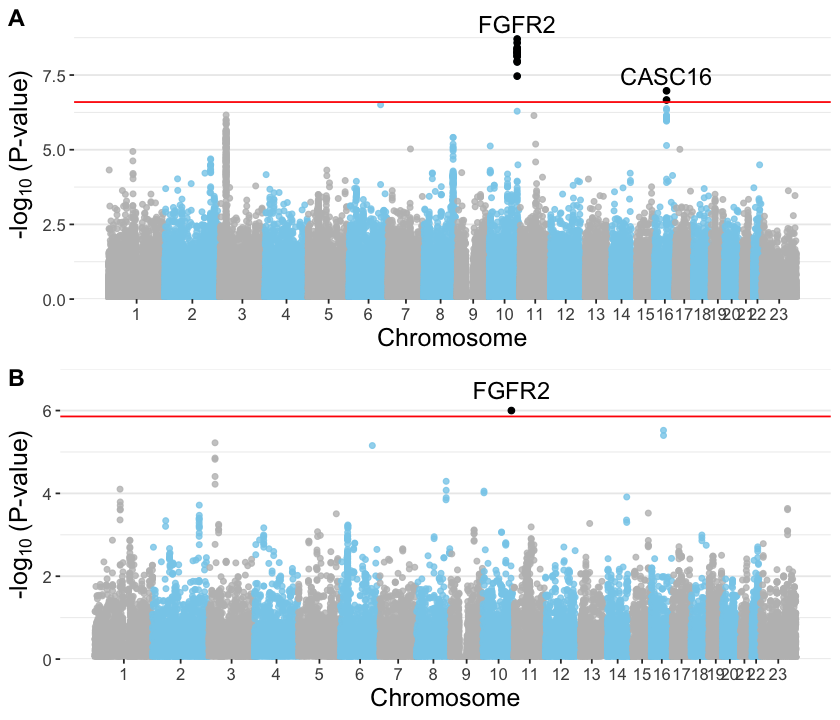

In [4]:
options(repr.plot.width=7, repr.plot.height=6)
f1 <- plot_grid(f1a, f1b, labels = c('A', 'B'), nrow = 2)
f1
ggsave('figures/figure_1.pdf', f1, width=7, height=6)

# Figure 3

In [5]:
set.seed(2)
vegas <- read_tsv('../results/preprocessing/scored_genes.vegas.txt', col_types = 'iciddddddcd') %>%
    select(Gene, `Top-0.1-pvalue`)
consensus_nodes <- read_tsv('../results/consensus/consensus.tsv', col_types = 'cllllllii')

consensus <- read_tsv('../results/preprocessing/BIOGRID-ORGANISM-Homo_sapiens-3.5.172.tab2.hgnc.txt') %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph %>%
    inner_join(consensus_nodes, by = "name")
class(consensus) <- 'igraph'

consensus <- consensus %>%
    ggnetwork %>%
    left_join(vegas, by = c('vertex.names' = 'Gene')) %>%
    mutate(vertex.names = as.character(vertex.names))
highlight <- consensus$num_methods == 3 | consensus$`Top-0.1-pvalue` < 0.001 | consensus$degree > 20 | consensus$known

f3 <- ggplot() +
    geom_edges(data = consensus, aes(x = x, y = y, xend = xend, yend = yend), size = 3, color = 'grey80') +
    geom_nodes(data = filter(consensus, !highlight), 
               aes(x = x, y = y, xend = xend, yend = yend), size = 6, fill = 'white', color = 'gray20', shape = 22) +
    geom_nodelabel_repel(data = filter(consensus, highlight), 
                         aes(x = x, y = y, xend = xend, yend = yend, label = vertex.names, color = known), 
                         size = 7, fill = 'white', force = 0.01) +
    theme_blank() +
    labs(size = '# methods') +
    scale_size_manual(values = c('2' = 6, '3' = 10)) +
    scale_color_manual(values = c('TRUE' = '#ff96a7', 'FALSE' = 'gray20')) +
    theme(legend.position = 'none')

Parsed with column specification:
cols(
  .default = col_character(),
  `#BioGRID Interaction ID` = col_double(),
  `Entrez Gene Interactor A` = col_double(),
  `Entrez Gene Interactor B` = col_double(),
  `BioGRID ID Interactor A` = col_double(),
  `BioGRID ID Interactor B` = col_double(),
  `Pubmed ID` = col_double(),
  `Organism Interactor A` = col_double(),
  `Organism Interactor B` = col_double()
)
See spec(...) for full column specifications.
Warning message in fortify.network(intergraph::asNetwork(model), ...):
“duplicated edges detected”Warning message:
“Column `vertex.names`/`Gene` joining factor and character vector, coercing into character vector”Warning message:
“Ignoring unknown aesthetics: xend, yend”Warning message:
“Ignoring unknown aesthetics: xend, yend”

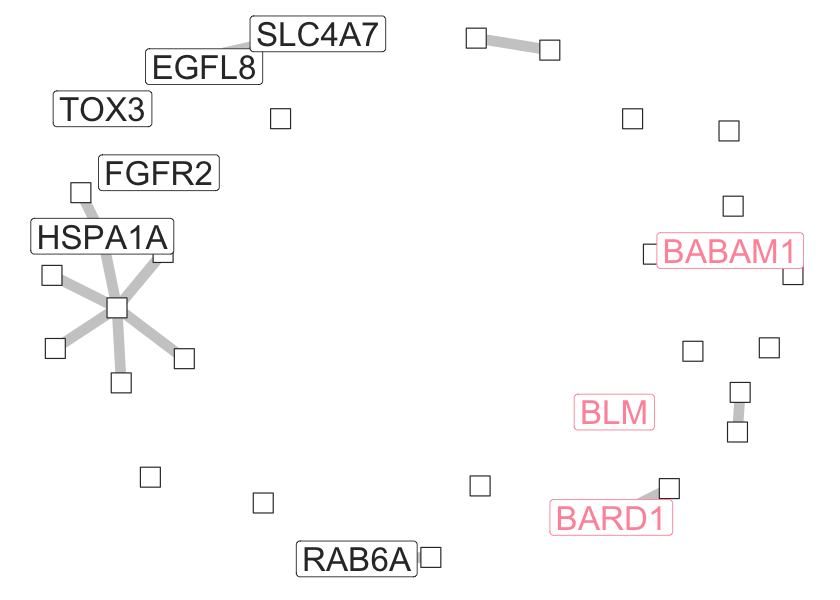

In [6]:
options(repr.plot.width=7, repr.plot.height=5)
f3
ggsave('figures/figure_3.pdf', f3, width=7, height=5)